--------------------------------------------------------------------------------
# Generador de descripciones de imágenes
Introducción a Deep Learning 

0231889 - **Abel Valle Chávez**
--------------------------------------------------------------------------------

## Procesamiento de datos
## Definición y entrenamiento de modelo

In [45]:
# Import, from ordenados al inicio del código para una carga eficiente.
import matplotlib.pyplot as plt
import numpy as np
import os
import string

from keras.applications.xception import Xception, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils import to_categorical

from os import path
from pickle import dump, load
from PIL import Image
from tqdm import tqdm

In [25]:
# Bloque de código para montar las carpetas de datos en drive.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [26]:
# Rutas de carpetas.
base_path        = "/content/drive/MyDrive/deep-learning/final-project"
dataset_text     = "/content/drive/MyDrive/deep-learning/final-project/flickr8k-text"
dataset_images   = "/content/drive/MyDrive/deep-learning/final-project/flickr8k-dataset"

# Bandera para extraer características (tarda ~1hr.).
extract_features_flag = False

In [27]:
# Función que carga un archivo de texto en memoria.
def load_doc(filename):
    # Se abre el archivo en modo lectura.
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [28]:
# Obtenemos todas las imágenes con sus descripciones (captions).
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [29]:
# Función para limpieza de datos.
def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            # Reemplazo de dash por espacio.
            img_caption.replace("-", " ")
            desc = img_caption.split()
            # Conversión a minúsculas.
            desc = [word.lower() for word in desc]
            # Remueve signos de puntuación.
            desc = [word.translate(table) for word in desc]
            # Remueve letras aisladas.
            desc = [word for word in desc if(len(word) > 1)]
            # Remueve palabras que tienen números.
            desc = [word for word in desc if(word.isalpha())]
            # Conversión a cadena.
            img_caption = ' '.join(desc)
            captions[img][i] = img_caption
    return captions

In [30]:
def text_vocabulary(descriptions):
    # Construye un vocabulario con palabras únicas.
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [31]:
# Función que guarda todas las descripciones en un archivo.
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()

In [32]:
# Prepara los datos en texto.
filename = dataset_text + "/Flickr8k.token.txt"
descriptions_file = base_path + "/descriptions.txt"

# Carga el archivo con todo el texto
# y lo mapea en un diccionario de descripciones de una imagen a 5 descripciones.
descriptions = all_img_captions(filename)
print("Tamaño de descripciones = ", len(descriptions))

# Limpieza de descripciones.
clean_descriptions = cleaning_text(descriptions)

# Construcción del vocabulario.
vocabulary = text_vocabulary(clean_descriptions)
print("Tamaño de vocabulario = ", len(vocabulary))

# Guardado de las descripciones en un solo archivo.
save_descriptions(clean_descriptions, descriptions_file)

Tamaño de descripciones =  8092
Tamaño de vocabulario =  8763


In [33]:
def extract_features(directory):
        model = Xception(include_top=False, pooling='avg')
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299, 299))
            image = np.expand_dims(image, axis=0)
            image = image / 127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

In [34]:
# Vector de 2048 características.
features_file = base_path + "/features.p"

# Si no se cuenta con el archivo features.p o para volver a generarlo,
# establecer la bandera en True.
if extract_features_flag:
    features = extract_features(dataset_images)
    dump(features, open(features_file, "wb"))

In [35]:
features = load(open(features_file, "rb"))

In [36]:
# Función para cargar las imágenes. 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

# Función para cargar las descripciones limpias.
def load_clean_descriptions(filename, photos):   
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

# Función que carga las características.
def load_features(photos):
    all_features = load(open(base_path + "/features.p", "rb"))
    # Se seleccionan las características que se utilizan.
    features = {k:all_features[k] for k in photos}
    return features

In [37]:
filename = dataset_text + "/Flickr_8k.trainImages.txt"
descriptions_file = base_path + "/descriptions.txt"

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions(descriptions_file, train_imgs)
train_features = load_features(train_imgs)

In [38]:
# Función que convierte un diccionario a una lista de descripciones.
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Función para tokenizar las descripciones.
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [39]:
# Se le asigna un índice a cada palabra y se guarda en el archivo tokenizer.p.
tokenizer_file = base_path + "/tokenizer.p"

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(tokenizer_file, 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [40]:
# Función para calcular el tamaño máximo de las descripciones.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [41]:
# Se crea una secuencia de pares input-output a partir de la descripción
# de imagen.

# Función generadora de datos mediante model.fit_generator().
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            # Recupera las características de la imagen.
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [input_image, input_sequence], output_word

# Función de creación de secuencias.
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # Se recorre cada descripción de la imagen.
    for desc in desc_list:
        # Codifica la secuencia.
        seq = tokenizer.texts_to_sequences([desc])[0]
        # Separa una secuencia en varias parejas de palabras.
        for i in range(1, len(seq)):
            # Separa en una pareja input, output.
            in_seq, out_seq = seq[:i], seq[i]
            # Rellena la secuencia input.
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Decodifica la secuencia output.
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Se agregan a las listas.
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [42]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [43]:
# Función que define el modelo para generar descripciones.
def define_model(vocab_size, max_length):
    modelpng_file = base_path + "/" + "model.png"
    
    # Características del modelo CNN que pasan de 2048 a 256 unidades.
    input_data1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(input_data1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Modelo LSTM.
    input_data2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_data2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Unión de los 2 modelos.
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    output_data = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Se conforma el modelo completo [imagen, secuencia] [palabra]
    model = Model(inputs=[input_data1, input_data2], outputs=output_data)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # Visualización del modelo.
    print(model.summary())
    plot_model(model, to_file=modelpng_file, show_shapes=True)
    
    return model

In [44]:
# Creación de la carpeta para guardar los modelos.
if not path.exists(base_path + "/models"):
    os.mkdir(base_path + "/models")
    
# Entrenamiento de modelo.
print('            Dataset:', len(train_imgs))
print('      Descripciones: train =', len(train_descriptions))
print('              Fotos: train =', len(train_features))
print('   Tam. Vocabulario:', vocab_size)
print('Tam. de Descripción:', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

# Dado que son 10 épocas, el último modelo se encuentra en el archivo model_9.h5.
models_path = base_path + "/models"
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(models_path + "/model_" + str(i) + ".h5")

            Dataset: 6000
      Descripciones: train = 6000
              Fotos: train = 6000
   Tam. Vocabulario: 7577
Tam. de Descripción: 32
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1939712     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 204

## Aplicación del modelo

In [54]:
# Funciones de aplicación.
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: No se puede abrir la imagen. Verifique la ruta y extensión.")
    image = image.resize((299, 299))
    image = np.array(image)

    # Para imágenes de 4 canales, se convierte en 3 canales.
    if image.shape[2] == 4:
        image = image[..., :3]

    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for (word, index) in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

def load_trained_models(tokenizer_file, models_path):
    model = load_model(models_path + "/model_9.h5")
    tokenizer = load(open(tokenizer_file, "rb"))
    xception_model = Xception(include_top=False, pooling="avg")
    return model, tokenizer, xception_model

def get_image_description(model, tokenizer, xception_model, max_length, img_path):
    photo = extract_features(img_path, xception_model)
    img = Image.open(img_path)
    # Quita los tokens 'start' y 'end'.
    description = generate_desc(model, tokenizer, photo, max_length)
    description = description.split(' ', 1)[1]
    description = description.rsplit(' ', 1)[0]
    # Se imprime la descripción y se muestra la imagen.
    print(description)
    plt.imshow(img)

In [55]:
# Carga de modelos entrenados.
# Ejecutar load_trained_models() una vez, para no cargar los modelos
# en cada imagen.
max_length = 32
model, tokenizer, xception_model = load_trained_models(tokenizer_file, models_path)

motorcycle racer is riding red motorcycle


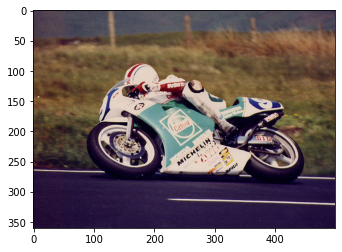

In [59]:
img_path = base_path + "/flickr8k-dataset/2554531876_5d7f193992.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two men playing baseball


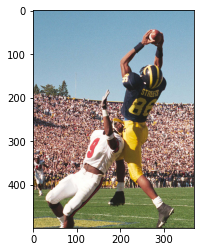

In [61]:
img_path = base_path + "/flickr8k-dataset/273248777_eaf0288ab3.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two women in red shirts are playing football on the street


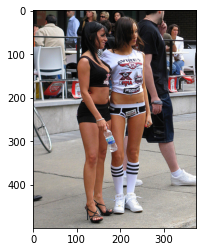

In [58]:
# Imágenes de prueba.
img_path = base_path + "/flickr8k-dataset/2925760802_50c1e84936.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

man in wetsuit is surfing


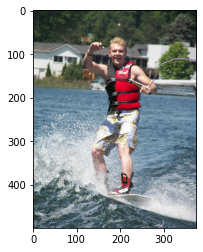

In [63]:
img_path = base_path + "/flickr8k-dataset/172092461_a9a9762e13.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

little boy in pink shirt is playing with toy in the backyard


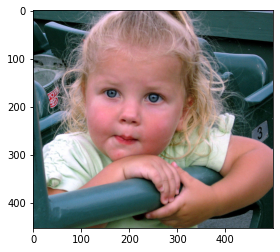

In [69]:
img_path = base_path + "/flickr8k-dataset/367925122_335ed279a8.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

dog is running through the grass


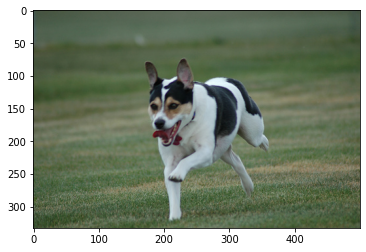

In [70]:
img_path = base_path + "/flickr8k-dataset/426920445_d07d1fd0f7.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

boy swims in pool


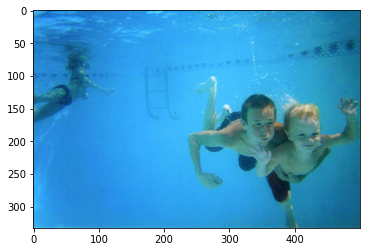

In [72]:
img_path = base_path + "/flickr8k-dataset/501699433_f8df386cf9.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two people are walking on snowy mountain


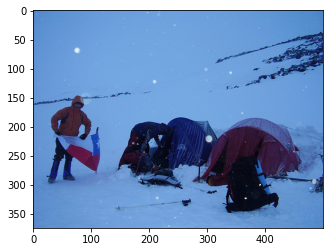

In [76]:
img_path = base_path + "/flickr8k-dataset/1584315962_5b0b45d02d.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

boy in red shirt is playing in the pool


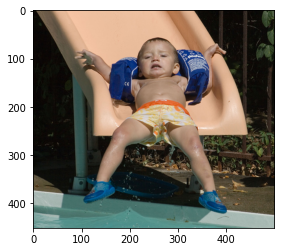

In [74]:
img_path = base_path + "/flickr8k-dataset/1303335399_b3facd47ab.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two men playing basketball


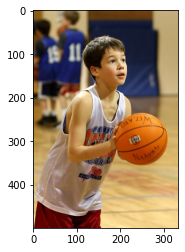

In [78]:
img_path = base_path + "/flickr8k-dataset/2251747182_6b67a3ab8b.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two people are riding on atv in the woods


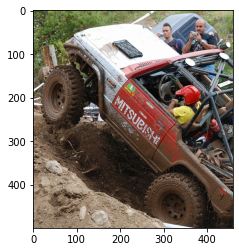

In [79]:
img_path = base_path + "/flickr8k-dataset/2409312675_7755a7b816.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two girls are playing in the surf


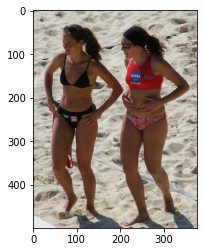

In [82]:
img_path = base_path + "/flickr8k-dataset/2883950737_3b67d24af4.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

### Casos con resultados no esperados

young boy in the bathtub with his tongue sticking out


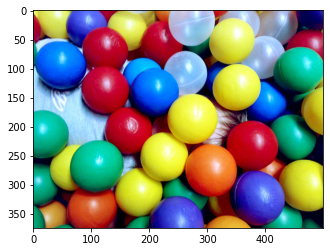

In [75]:
img_path = base_path + "/flickr8k-dataset/1433397131_8634fa6664.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

man in black shirt and black shirt is sitting on bench


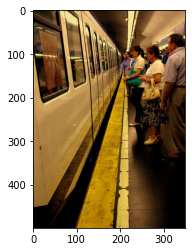

In [83]:
img_path = base_path + "/flickr8k-dataset/2981702521_2459f2c1c4.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

man in black shirt and sunglasses is sitting on bench


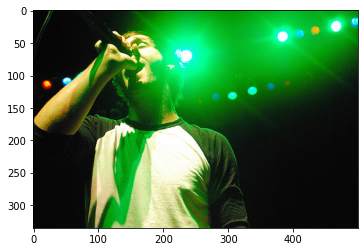

In [84]:
img_path = base_path + "/flickr8k-dataset/3049770416_0fb1954315.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two people are sitting on the grass in front of the water


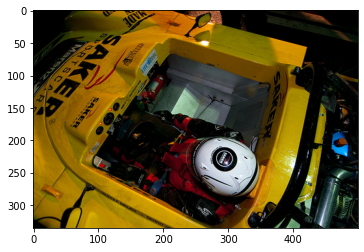

In [85]:
img_path = base_path + "/flickr8k-dataset/3171347658_f0d5469c56.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)

two girls are playing football on the grass


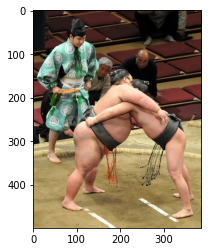

In [86]:
img_path = base_path + "/flickr8k-dataset/3220140234_e072856e6c.jpg"
get_image_description(model, tokenizer, xception_model, max_length, img_path)